In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


SEED = 314159
TRAIN_TEST_SPLIT = 0.80

data_path = r"C:\Users\nikol_ri8fhbe\Documents\ml"

In [44]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
                           n_redundant=5, random_state=42)

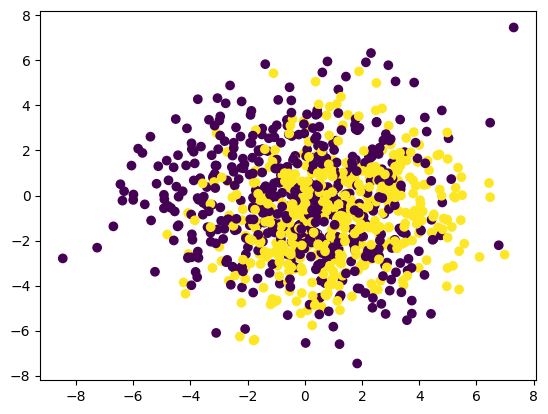

In [45]:
plt.scatter(X[:, 2], X[:, 3], c=y)

# Ансамбли: бустинги


Бустинг строится последовательно: каждое следующее дерево в нем обучается на основе результатов предыдущего, пытаясь уменьшить его ошибку. Как следствие, композиция будет иметь меньшее смещение, чем исходные базовые модели. Поэтому логично в качестве базовых моделей использовать те, которые изначально обладают небольшим разбросом и высоким смещением. Вопрос: какие это будут модели?
Еще одно соображение для выбора сильно смещенных моделей в том, что они банально быстрее учатся. Так как невозможно распараллелить обучение базовых моделей, то скорость их настройки становится серьезным вопросом. 

Что интересно, бустинги не очень хорошо работают с однородными данными - поэтому их нечасто применяют для текстов.

Расссмотрим квадратичную функцию потерь и композицию следующего вида: $ a = b_1 +  b_2 + ... + b_N $
Обучим только одно дерево $ a = b_1 $. Найдем примеры, для которых оно ошибается в  предсказании. Обучим для них еще одно дерево - $ b_2 $, которое будет предсказывать ошибку первого. Будем повторять это, пока не наберем K деревьев. Примерно так на верхнем уровне обучается бустинг. 


In [46]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

def eval_classifier(clf):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=43)
    n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return np.mean(n_scores), np.std(n_scores)

In [47]:
results_accuracy = pd.DataFrame(0.0,
                                columns=["W/o ensembling", 'Bagging', "Bagging_with_mf", 'AdaBoost'],
                                index=['deep DTC', '1-level DTC', 'LR', 'SVC'])

In [48]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier())

results_accuracy.loc['deep DTC', 'W/o ensembling'] = acc_mean
print(f"{acc_mean:.2f}, +- {acc_std:.2f}")

0.80, +- 0.05


In [49]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier(max_depth=1))

results_accuracy.loc['1-level DTC', 'W/o ensembling'] = acc_mean
print(f"{acc_mean:.2f} +- {acc_std:.2f}")

0.68 +- 0.04


In [50]:
from sklearn.ensemble import BaggingClassifier

In [51]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['deep DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.87, 0.03


In [52]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['1-level DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.68, 0.04


In [53]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['deep DTC', 'Bagging_with_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.87, 0.04


In [54]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['1-level DTC', 'Bagging_with_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.69, 0.04


In [55]:
results_accuracy

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.796000,0.865667,0.867667,0.0
1-level DTC,0.683333,0.680000,0.693667,0.0
LR,0.000000,0.000000,0.000000,0.0
SVC,0.000000,0.000000,0.000000,0.0


**Задание**: Дополните таблицу: обучите также логистическую регрессию с беггингом и без него.

In [56]:
from sklearn.linear_model import LogisticRegression

acc_mean, acc_std = eval_classifier(LogisticRegression(max_iter=1000))
results_accuracy.loc['LR', 'W/o ensembling'] = acc_mean
print(f"Logistic Regression (без ансамблирования): {acc_mean:.2f} +- {acc_std:.2f}")

acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(max_iter=1000), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))
results_accuracy.loc['LR', 'Bagging'] = acc_mean
print(f"Logistic Regression (Bagging): {acc_mean:.2f} +- {acc_std:.2f}")

acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(max_iter=1000), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))
results_accuracy.loc['LR', 'Bagging_with_mf'] = acc_mean
print(f"Logistic Regression (Bagging с max_features=0.8): {acc_mean:.2f} +- {acc_std:.2f}")

results_accuracy


Logistic Regression (без ансамблирования): 0.81 +- 0.03
Logistic Regression (Bagging): 0.81 +- 0.03
Logistic Regression (Bagging с max_features=0.8): 0.81 +- 0.03


,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.796000,0.865667,0.867667,0.0
1-level DTC,0.683333,0.680000,0.693667,0.0
LR,0.811333,0.811000,0.812000,0.0
SVC,0.000000,0.000000,0.000000,0.0


## AdaBoost

AdaBoost обучает каждый следующий классификатор на объектах, на которых ошибаются предыдущие (объекты с ошибками получают больший вес, без ошибок — меньший).

In [57]:
from sklearn.ensemble import AdaBoostClassifier

In [58]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate=1.0))

results_accuracy.loc['deep DTC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.79, 0.05


In [59]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=1.0))

results_accuracy.loc['1-level DTC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.81, 0.04


In [60]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

results_to_show = results_accuracy.copy()

results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.796,0.866,0.868,0.786
1-level DTC,0.683,0.680,0.694,0.813
LR,0.811,0.811,0.812,0.000
SVC,0.000,0.000,0.000,0.000


**Задание:** выясните, дадут ли улучшение бэггинг и бустинг над линейной регрессией. Объясните, почему так.

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(max_iter=1000), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False)
)
results_accuracy.loc['LR', 'Bagging'] = acc_mean
print(f"Bagging LR: {acc_mean:.3f}, {acc_std:.3f}")

acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(max_iter=1000), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False)
)
results_accuracy.loc['LR', 'Bagging_with_mf'] = acc_mean
print(f"Bagging_with_mf LR: {acc_mean:.3f}, {acc_std:.3f}")

acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(LogisticRegression(max_iter=1000), n_estimators=50, learning_rate=1.0)
)
results_accuracy.loc['LR', 'AdaBoost'] = acc_mean
print(f"AdaBoost LR: {acc_mean:.3f}, {acc_std:.3f}")

results_accuracy


Bagging LR: 0.809, 0.035
Bagging_with_mf LR: 0.809, 0.034
AdaBoost LR: 0.798, 0.039


,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.796000,0.865667,0.867667,0.786333
1-level DTC,0.683333,0.680000,0.693667,0.813000
LR,0.811333,0.809333,0.809000,0.798000
SVC,0.000000,0.000000,0.000000,0.000000


Бэггинг хорошо работает для моделей с высокой дисперсией (например, глубокие деревья).

Линейная регрессия — стабильная, с маленькой дисперсией, но высоким смещением.
Поэтому бэггинг мало помогает линейной регрессии.

Бустинг (особенно AdaBoost) обучает последующие модели на ошибках предыдущих.

Линейная регрессия — слишком простая модель. Если данные нелинейные, бустинг над линейной регрессией не сможет построить сложные зависимости, т.к. каждая база — всё равно "прямая линия".

Вывод: и бэггинг, и бустинг над линейной регрессией почти не улучшают качество (а иногда даже ухудшают или просто бесполезны).

Вопрос: Почему AdaBoost хуже работает на глубоких деревьях?

AdaBoost предполагает, что базовые модели простые и слабые. Его стратегия:

Постепенно исправлять ошибки слабых моделей.
Собирать сильного классификатора из кучи простых слабых моделей.

Глубокие деревья сами по себе — очень сильные модели:

Они легко переобучаются под конкретные данные.
Могут "захватывать" шум в данных.
Поэтому при использовании глубоких деревьев AdaBoost начинает переобучаться очень быстро, вместо постепенного исправления ошибок.

# Градиентный бустинг

Рассмотрим композицию $a = \sum_{i} {\gamma_i b_i}$. Для начала выбирается какой-нибудь простой $\gamma_0, b_0$ (например, 0 и среднее). Формально каждая N-ая модель, начиная со второй, пытается приблизиить антиградиент функционала ошибки, взятый в точках ${z_i=a_{N-1}(x_i)}$:
$$s_i = -\dfrac{\partial L(y, z)}{\partial z}|_{z=a_{N-1}}$$
Подбор алгоритма при этом производится, приближая эту ошибку c точки зрения квадратичной функции потерь.
$$ b_i = arg \min_{b \in \mathcal{B}} {\sum (b_i(x) - s_i)^2} $$

Градиентный бустинг - довольно мощная метамодель, с огромным количеством параметров и хитростей. Мы сегодня остановимся только на основных. Для начала рассмотрим самый стандартный бустинг с использованием деревьев решений (CART). Параметры базовых моделей такие же, как и раньше, но настройка амого бустинга довольно сложна!

Важный вопрос при обучении модели - какую функцию ошибок выбрать? Какая задача возникает при обработке датасета с вином?

Для того, чтобы оценивать модель, полезны различные метрики - численные характеристики ее качества. При этом бустинги настолько галантны, что предоставляют нам возможность оценивать метрики прямо при обучении. Для этого необходимо задать тип метрики в конструкторе и eval_set при запуске fit().

На практике обычно используется один из трех вариантов бустинга - Xgboost, LightGBM или CatBoost.

### [XGBoost](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf).
Плюсы:
- Позволяет легко паралелить вычисления (например на спарке)
- Легко использовать с sklearn и numpy (но с потерей производительности)
- Поддерживается обработка разреженных данных
- Предсортированные блоки, кэши, шардирование

Минусы:
- Нет поддержки GPU

[документация](https://xgboost.readthedocs.io/en/latest/)

  
### [LightGBM](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
Плюсы:
- Поддержка GPU
- Метод Фишера для работы с категориальными признаками
- Уменьшение размера обучающей выборки (GOSS)
- Объединение разреженных признаков (EFB)

Минусы:
- Итерфейс не совместим с sklearn/numpy

[документация](https://lightgbm.readthedocs.io/en/latest/Python-API.html)

### [CatBoost](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
Плюсы:
- Поддержка GPU
- Легко использовать с sklearn и numpy
- Более продвинутая работа с категориальными фичами
- Наши слоны
  
Минусы:
- Бывает работает хуже (возможно слабее эвристики), но с категориальными фичами — хорошо

[документация](https://catboost.ai/docs/concepts/python-quickstart.html)


In [62]:
from catboost import CatBoostClassifier

acc_mean, acc_std = eval_classifier(
    CatBoostClassifier(
        iterations=10,
        depth=1,
        learning_rate=1,
        loss_function='Logloss',
        verbose=True, 
        task_type='CPU'))

сat_boost = acc_mean

results_accuracy.loc['1-level DTC', 'CatBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.76, 0.04


In [63]:
from catboost import CatBoostClassifier

acc_mean, acc_std = eval_classifier(
    CatBoostClassifier(
        iterations=10,
        learning_rate=1,
        loss_function='Logloss',
        verbose=True, 
        task_type='CPU'))

сat_boost = acc_mean

results_accuracy.loc['deep DTC', 'CatBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.86, 0.03


In [64]:
from xgboost import XGBClassifier
acc_mean, acc_std = eval_classifier(XGBClassifier(objective='binary:logistic', random_state=42))

xg_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

results_accuracy.loc['deep DTC', 'XGBoost'] = acc_mean

0.92, 0.03


In [65]:
acc_mean, acc_std = eval_classifier(XGBClassifier(objective='binary:logistic', max_depth=1, random_state=42))

xg_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

results_accuracy.loc['1-level DTC', 'XGBoost'] = acc_mean

0.84, 0.03


In [66]:
results_to_show = results_accuracy.copy()
results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost,CatBoost,XGBoost
deep DTC,0.796,0.866,0.868,0.786,0.862,0.920
1-level DTC,0.683,0.680,0.694,0.813,0.759,0.841
LR,0.811,0.809,0.809,0.798,nan,nan
SVC,0.000,0.000,0.000,0.000,nan,nan


In [67]:
import lightgbm as lgb

train_data = lgb.Dataset(X, label=y)

param = {'num_leaves': 31, 
         'objective': 'multiclass', 
         'num_class': 2, 
         'metric': ['multi_logloss']}

num_round = 10
boost = lgb.train(param, train_data, num_boost_round=10)

lg_boost = (boost.predict(X).argmax(axis=-1) == y).mean()

results_accuracy.loc['deep DTC', 'LightGBM'] = lg_boost
print(f"{lg_boost:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 20
[LightGBM] [Info] Start training from score -0.689155
[LightGBM] [Info] Start training from score -0.697155
0.95


In [68]:
results_to_show = results_accuracy.copy()

results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost,CatBoost,XGBoost,LightGBM
deep DTC,0.796,0.866,0.868,0.786,0.862,0.920,0.947
1-level DTC,0.683,0.680,0.694,0.813,0.759,0.841,nan
LR,0.811,0.809,0.809,0.798,nan,nan,nan
SVC,0.000,0.000,0.000,0.000,nan,nan,nan


## Пример
Рассмотрим реальный датасет, и на его примере попробуем поработать с бустингом.

In [70]:
df = pd.read_csv('diabetes.csv')

X = df.drop(columns='Outcome')
Y = df['Outcome'] 

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)


In [71]:
model = XGBRegressor(n_estimators=100, learning_rate=1, seed=SEED)
fit_params = {"eval_set":[(X_train, y_train),(X_test, y_test)], "verbose": False}
# Add verbose=False to avoid printing out updates with each cycle
model.fit(X_train, y_train,
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [72]:
results = model.evals_result()

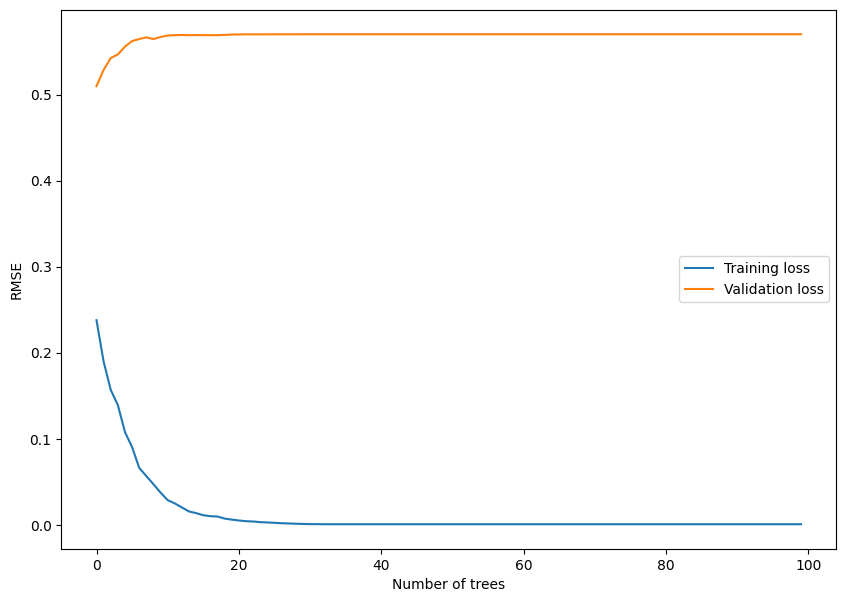

In [73]:
error_function = "rmse"
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][error_function], label="Training loss")
plt.plot(results["validation_1"][error_function], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

Как мы видим, хотя лосс при обучении падал и падал, на валидации метрики перестали улучшаться довольно рано. Это довольно плохой знак. Однако говорит ли это о катастрофической ситуации? Проверим переобучение с помощью кросс-валидации.

In [74]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                            return_train_score=True)
print("Train RMSE is", -cv_results['train_neg_root_mean_squared_error'].mean())
print("Test RMSE is", -cv_results['test_neg_root_mean_squared_error'].mean())


Train RMSE is 0.000744145450880751
Test RMSE is 0.5135758578777313


Кажется, у нас действительно серьезные проблемы. Попробуем уменьшить скорость обучения.


In [75]:
# train and eval model with smaller lr
model = XGBRegressor(n_estimators=100, learning_rate=0.01, seed=SEED)
fit_params = {"eval_set":[(X_train, y_train),(X_test, y_test)], "verbose": False}
# Add verbose=False to avoid printing out updates with each cycle
model.fit(X_train, y_train,
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

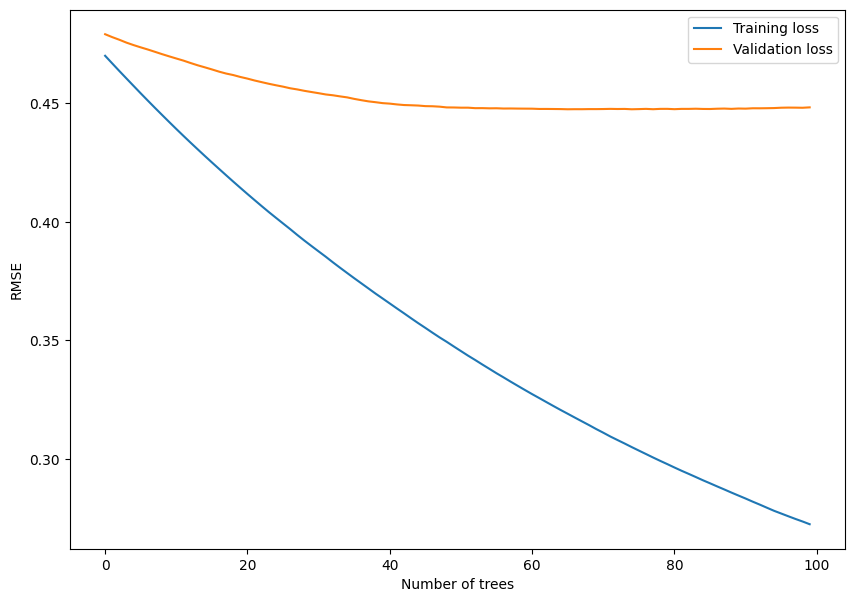

In [76]:
# plot results
results = model.evals_result()
error_function = "rmse"
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][error_function], label="Training loss")
plt.plot(results["validation_1"][error_function], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

Помогло ли это? Попробуем получить результаты лучше, поиграв с параметрами.

In [77]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                            return_train_score=True)
print("Train RMSE is", -cv_results['train_neg_root_mean_squared_error'].mean())
print("Test RMSE is", -cv_results['test_neg_root_mean_squared_error'].mean())


Train RMSE is 0.31414556205272676
Test RMSE is 0.40764451324939727


In [ ]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=SEED
)

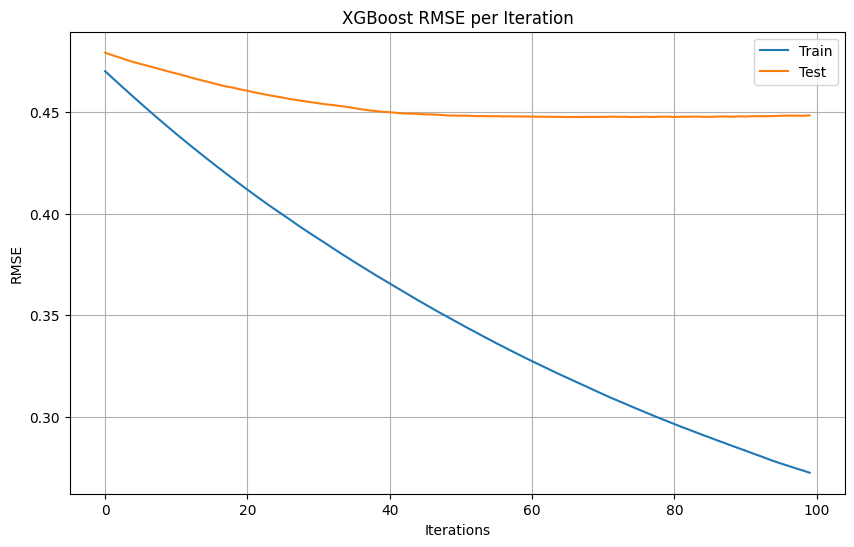

In [ ]:
fit_params = {"eval_set": [(X_train, y_train), (X_test, y_test)], "verbose": False}

model.fit(X_train, y_train, **fit_params)

results = model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE per Iteration')
plt.grid(True)
plt.show()

Так как параметров довольно много, может быть разумно автоматизировать их поиск. Для этого воспользуемся поиском по решетке.

In [79]:
from sklearn.model_selection import GridSearchCV

xgboost_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgboost_best_grid = GridSearchCV(model, xgboost_params,
                                 cv=7, n_jobs=-1,
                                 return_train_score=True)

xgboost_best_grid.fit(X_train, y_train, **fit_params)

GridSearchCV(cv=7,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             return_train_score=True)

In [80]:
print("Best parameters found: ", xgboost_best_grid.best_params_)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}


Давайте проверим, какую точность мы получим с лучшими параметрами.

In [81]:
best_model = xgboost_best_grid.best_estimator_

# Оцениваем качество через кросс-валидацию
cv_results = cross_validate(best_model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                             return_train_score=True)

print("Train RMSE is", -cv_results['train_neg_root_mean_squared_error'].mean())
print("Test RMSE is", -cv_results['test_neg_root_mean_squared_error'].mean())

Train RMSE is 0.33037184178829193
Test RMSE is 0.395032799243927


**Задание:** Проведите обучение и с LightGBM/CatBoost. Какие лучшие точности у вас получилось получить?

In [84]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

lgb_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=SEED,
    verbose=-1
)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

cv_lgb = cross_validate(lgb_model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"], return_train_score=True)
print("LightGBM - Train RMSE:", -cv_lgb['train_neg_root_mean_squared_error'].mean())
print("LightGBM - Test RMSE:", -cv_lgb['test_neg_root_mean_squared_error'].mean())


cat_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=5,
    loss_function='RMSE',
    random_seed=SEED,
    verbose=False
)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test))

cv_cat = cross_validate(cat_model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"], return_train_score=True)
print("CatBoost - Train RMSE:", -cv_cat['train_neg_root_mean_squared_error'].mean())
print("CatBoost - Test RMSE:", -cv_cat['test_neg_root_mean_squared_error'].mean())


LightGBM - Train RMSE: 0.24667112924639567
LightGBM - Test RMSE: 0.41814953420138734
CatBoost - Train RMSE: 0.3062391090002676
CatBoost - Test RMSE: 0.3934452918625602


**Задание:** Постройте графики предсказаний для первых двух PCA фичей для бустингов разной глубины/разного числа деревьев.

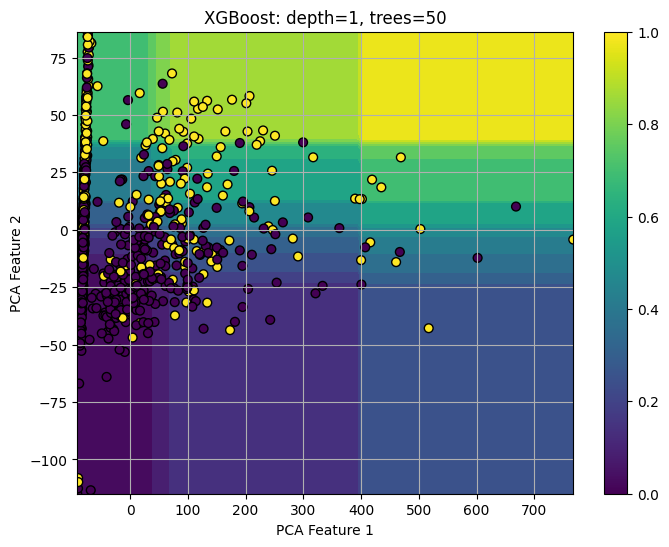

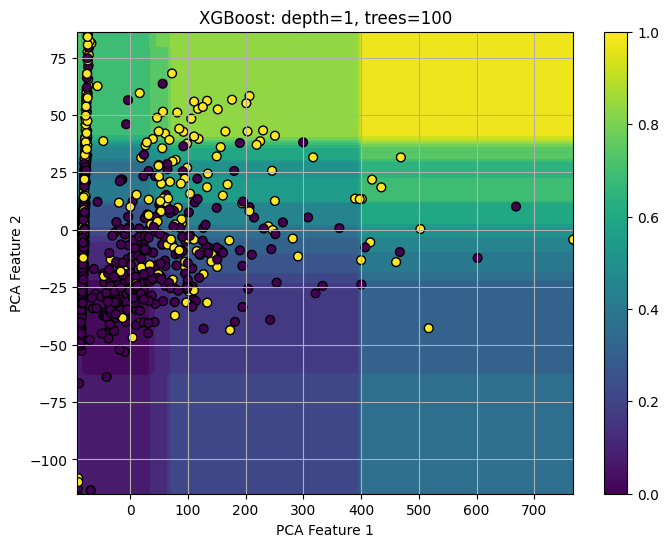

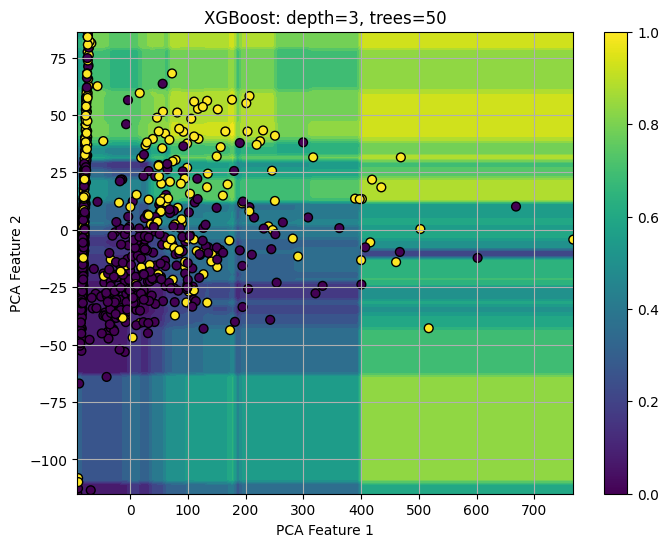

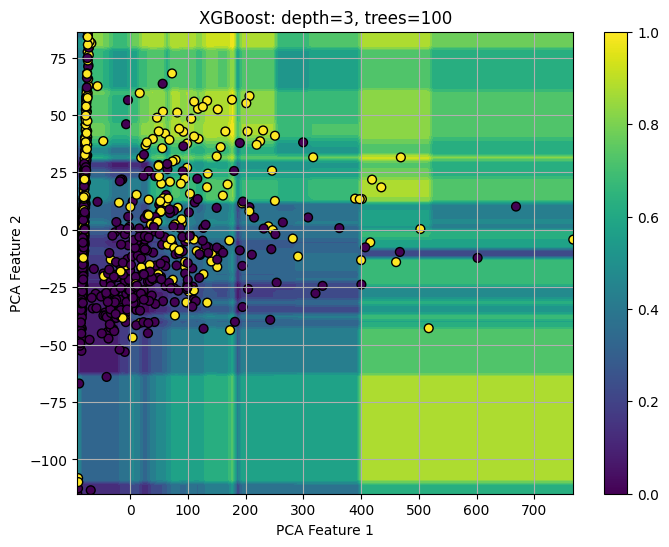

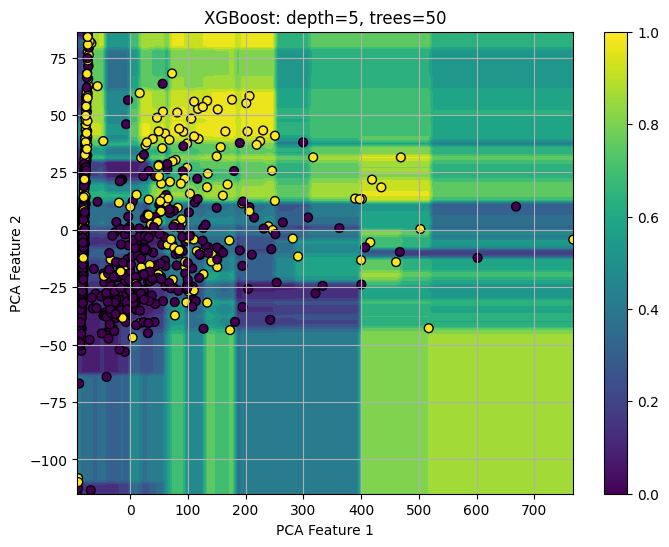

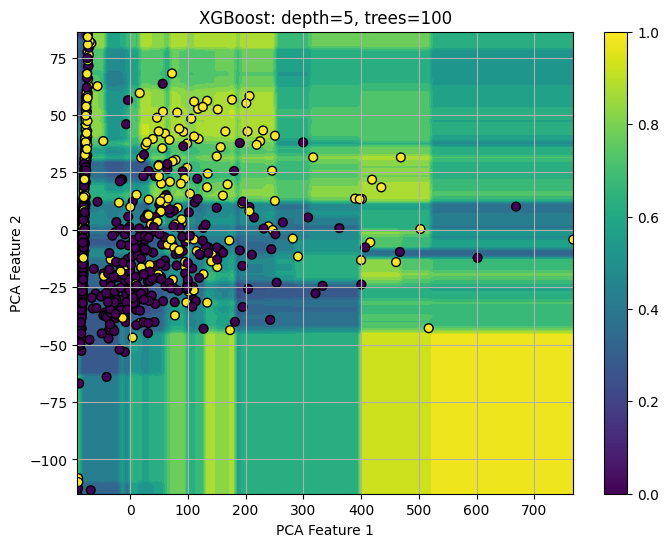

In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

depths = [1, 3, 5]
trees = [50, 100]

for depth in depths:
    for n_estimators in trees:
        model = XGBRegressor(
            max_depth=depth,
            n_estimators=n_estimators,
            learning_rate=0.1,
            seed=SEED
        )
        model.fit(X_pca, Y)

        xx, yy = np.meshgrid(
            np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 100),
            np.linspace(X_pca[:, 1].min(), X_pca[:, 1].max(), 100)
        )
        preds = model.predict(np.c_[xx.ravel(), yy.ravel()])
        preds = preds.reshape(xx.shape)

        plt.figure(figsize=(8,6))
        plt.contourf(xx, yy, preds, levels=20, cmap='viridis')
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, edgecolor='k', cmap='viridis', s=40)
        plt.colorbar()
        plt.title(f"XGBoost: depth={depth}, trees={n_estimators}")
        plt.xlabel('PCA Feature 1')
        plt.ylabel('PCA Feature 2')
        plt.grid(True)
        plt.show()

**Задание**: Постройте график зависимости точности от глубины

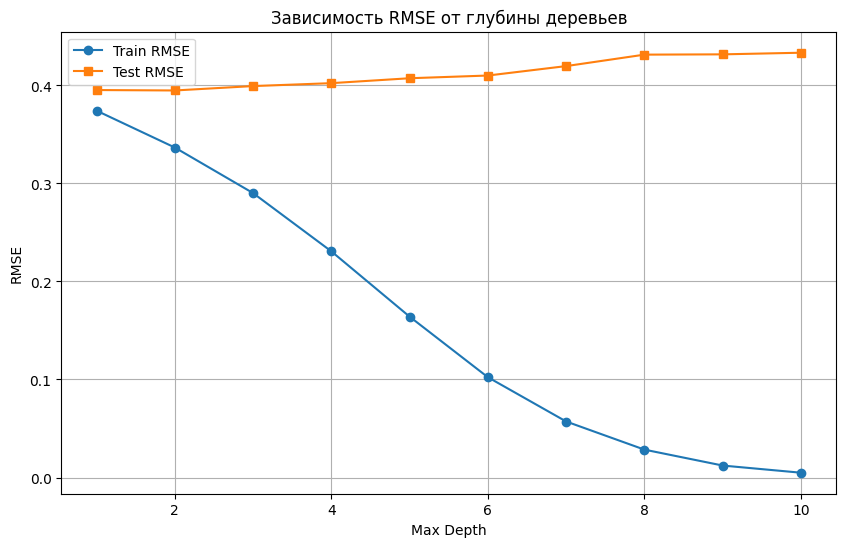

In [86]:
depth_range = range(1, 11)
train_rmse = []
test_rmse = []

for depth in depth_range:
    model = XGBRegressor(
        max_depth=depth,
        n_estimators=100,
        learning_rate=0.1,
        seed=SEED
    )
    scores = cross_validate(model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                             return_train_score=True)
    train_rmse.append(-scores['train_neg_root_mean_squared_error'].mean())
    test_rmse.append(-scores['test_neg_root_mean_squared_error'].mean())

plt.figure(figsize=(10,6))
plt.plot(depth_range, train_rmse, label="Train RMSE", marker='o')
plt.plot(depth_range, test_rmse, label="Test RMSE", marker='s')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Зависимость RMSE от глубины деревьев')
plt.legend()
plt.grid(True)
plt.show()
